In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

/var/folders/qm/y3ntm4w54lv2x8p86n_p1ml80000gn/T/ipykernel_809/3771961670.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [26]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataset to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data),dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need !
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 1

In [27]:
# seperate the daa into DataLoaders

# use scikitlearn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=.2)

# then convert them into pytorch datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [28]:
# Create the model and a training regimen
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()
        
        # layers
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)
        
        # parameters
        self.dr = dropoutRate
        
    # forward pass
    def forward(self,x):
        
        # input
        x = F.relu(self.input(x))
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
        
        # hidden 
        x = F.relu(self.hidden(x))
        x = F.dropout(x,p=self.dr,training=self.training)
        
        # output
        x = self.output(x)
        return x

In [29]:
# test the model
tmpnet = theModelClass(.25)

# run some random data through
tmpdata = torch.randn((10,4))
yhat = tmpnet(tmpdata)
yhat

tensor([[-1.0524e-01, -2.0372e-01, -1.4890e-01],
        [-2.0550e-01, -7.2781e-02,  1.3066e-01],
        [-1.5565e-01, -1.5685e-01,  7.0018e-02],
        [-4.0473e-01, -1.2285e-02,  4.6558e-01],
        [-1.8025e-02, -2.0114e-01,  3.2934e-02],
        [-2.1248e-02, -1.8698e-01,  2.5495e-03],
        [-1.7052e-01, -1.5003e-01,  8.1726e-02],
        [-7.5938e-02, -1.9057e-01, -9.2517e-02],
        [-1.1053e-01, -2.5756e-01, -4.5126e-04],
        [-8.4712e-02, -1.4491e-01,  2.1778e-01]], grad_fn=<AddmmBackward0>)

In [30]:
# a function that creates the ANN model:

def createANewModel(dropoutrate):
    
    # grab an instance of the model class
    ANNiris = theModelClass(dropoutrate)
    
    # loss function
    lossfun = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005)
    
    return ANNiris,lossfun,optimizer

In [47]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():
    
    # initialize accuracies as empties (not storing losses here)
    trainAcc = []
    testAcc = []
    
    # loop over epochs
    for epochi in range(numepochs):
        
        # switch learning on
        ANNiris.train()
        
        # loop over training data batches
        batchAcc = []
        for X,y in train_loader:
            
            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # compute training accuracy just for this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            
        # end of batch loop...
        trainAcc.append(np.mean(batchAcc))
        
        # test accuracy
        ANNiris.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        predlabels = torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
    
    # function output
    return trainAcc,testAcc

In [48]:
# Now for the real work!

# create a model
dropoutrate = .0
ANNiris,lossfun,optimizer= createANewModel(dropoutrate)

# train the modelz
trainAcc,testAcc = trainTheModel()

Text(0.5, 1.0, 'Dropout rate= 0')

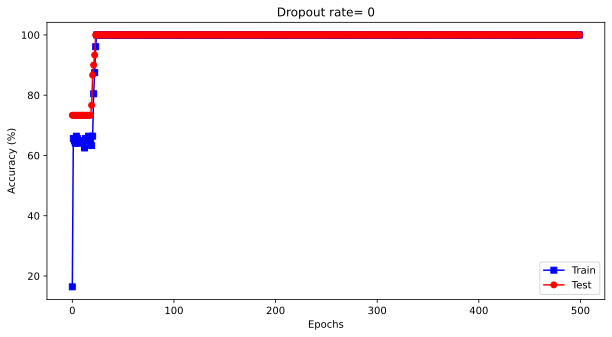

In [49]:
# plot the results
fig = plt.figure(figsize=(10,5))
plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate= %g'%dropoutrate)

In [50]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):
    
    # create and train the model
    ANNiris,lossfun,optimizer = createANewModel(dropoutRates[di])
    trainAcc,testAcc = trainTheModel()
    
    # store accuracies
    results[di,0] = np.mean(trainAcc[-50:])
    results[di,1] = np.mean(testAcc[-50:])
    
    

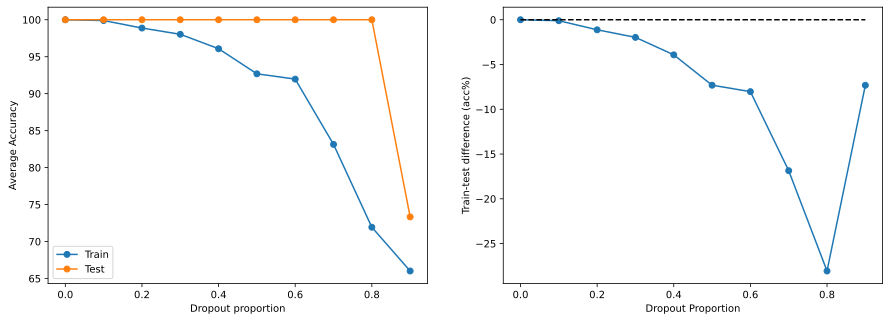

In [51]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
    
ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Train','Test'])
    
ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout Proportion')
ax[1].set_ylabel('Train-test difference (acc%)')
    
plt.show()